In [1]:
import cv2
import torch
import matplotlib
import numpy as np
import glob
from skimage.io import imread, imshow
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchvision import models
import os
device = torch.device('cuda' if torch.cuda.is_available else 'cpu') 
print(device)

cuda


In [2]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Sequential(
        
        torch.nn.Conv2d(3,32, kernel_size=5, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
            
        torch.nn.Conv2d(32,64, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        
        torch.nn.Conv2d(64,128, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(128,128, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        )
        
        self.cls = torch.nn.Sequential(
        torch.nn.Linear(128*12*13, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,2)
        )
        
    def forward(self, x):
        out = self.conv(x)
        # print(out.shape)
        out = out.reshape(-1,128*12*13)
        out = self.cls(out)
        return out

In [3]:
transforms = transforms.Compose([
        transforms.Resize((224,244)),
        transforms.ToTensor(),
    ])
train_ds = ImageFolder(r"./data/train/", transform=transforms)
test_ds = ImageFolder(r"./data/test/", transform=transforms)

validation_split = .2
dataset_size = len(train_ds)
print(str(dataset_size) + " rows")
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataloader_train = torch.utils.data.DataLoader(train_ds, batch_size=16, num_workers=4, sampler=train_sampler)
dataloader_val = torch.utils.data.DataLoader(train_ds, batch_size=16, num_workers=4, sampler=valid_sampler)
dataloader_test = torch.utils.data.DataLoader(test_ds, batch_size=16, num_workers=4)

2637 rows


In [4]:
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters())
lossf = torch.nn.CrossEntropyLoss()

In [39]:
def train_loop(model, lossf,optimizer, train_dl, val_dl ,device, epochs=50, tolerance=1e-3, early_stop=True):
    # model = model.to(device)

    hist = {"epoch": 1}
    train_loss ={}
    val_loss = {}

    train_acc = {}
    val_acc = {}

    best_loss = np.inf
    loop = tqdm(range(epochs))

    loss_function = lossf
    optimizer = optimizer
    
    for epoch in loop:
        losses = []
        accs = []
        model.train()
        for batch in train_dl:
            img, label = batch
            img = img.float().to(device)
            label = label.to(device)

            
            output = model(img)
            loss = loss_function(output, label)
            losses.append(loss.item())

            model.zero_grad()
            loss.backward()
            optimizer.step()
            
            prediction = output.argmax(1)
            acc = (prediction == label).sum()/len(label)
            accs.append(acc.cpu())
            
            
        losses_val = []
        accs_val= []
        model.eval()
        with torch.no_grad():
            for batch in val_dl:
                img, label = batch
                img = img.float().to(device)
                label = label

                output = model(img).detach().cpu()

                loss = loss_function(output, label)
                losses_val.append(loss.item())
                prediction = output.argmax(1)
                acc = (prediction == label).sum()/len(label)

                accs_val.append(acc.cpu())
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss = round(np.mean(losses),3), val_loss = round(np.mean(losses_val), 3))
        
        train_loss.update({epoch: np.mean(losses)})
        val_loss.update({epoch: np.mean(losses_val)})
        train_acc.update({epoch: np.mean(accs)})
        val_acc.update({epoch: np.mean(accs_val)})

        # Early stopping
        if early_stop:
            if abs(best_loss -  np.mean(losses_val)) < tolerance:
                print(f"At Epoch {epoch+1} the model obtained the best results. Stopping")
                # torch.save(model.model_state_dict(), "first_train_model.pth")
                break
            else:
                best_loss =  np.mean(losses_val)
        hist = {"epoch": epoch+1}


    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 10))
    ax0.plot(train_loss.keys(), train_loss.values(),'r')
    ax0.plot(val_loss.keys(), val_loss.values())
    ax0.legend(['train', 'val'])
    ax0.title.set_text("Loss")
    ax1.plot(train_acc.keys(), train_acc.values(),'r')
    ax1.plot(val_acc.keys(), val_acc.values())
    ax1.legend(['train', 'val'])
    ax1.title.set_text("Acc")
    return hist

In [6]:
def test_loop(model, lossf, test_dl ,device):

    loss_function = lossf

    losses_val = []
    accs_val= []

    model.eval()
    with torch.no_grad():
        for batch in test_dl:
            img, label = batch
            img = img.float().to(device)
            label = label

            output = model(img).detach().cpu()

            loss = loss_function(output, label)
            losses_val.append(loss.item())
            prediction = output.argmax(1)
            acc = (prediction == label).sum()/len(label)

            accs_val.append(acc.cpu())
    
    print(f"The model obtained an accuracy of {np.mean(accs_val):.3f}, and a loss of {np.mean(losses_val):.3f}")

Epoch [20/20]: 100%|██████████| 20/20 [04:17<00:00, 12.86s/it, loss=0.19, val_loss=0.633]


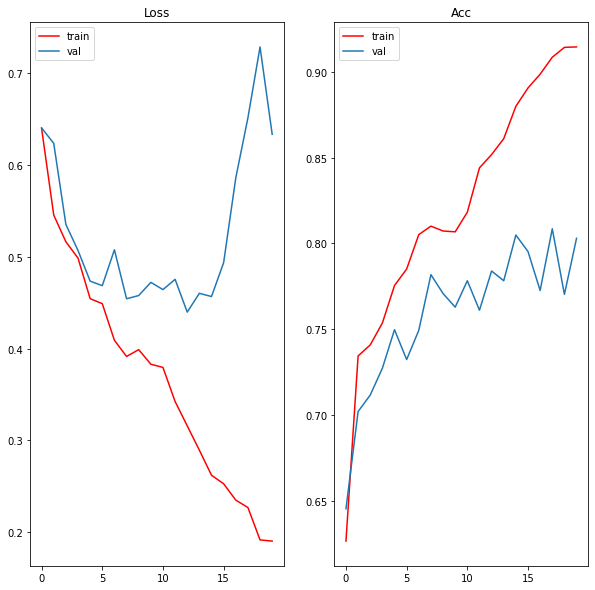

In [8]:
hist = train_loop(model, lossf, optimizer, dataloader_train, dataloader_val, device, epochs=20,early_stop=False)

In [9]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

Epoch [5/5]: 100%|██████████| 5/5 [01:05<00:00, 13.18s/it, loss=0.1, val_loss=1.16]


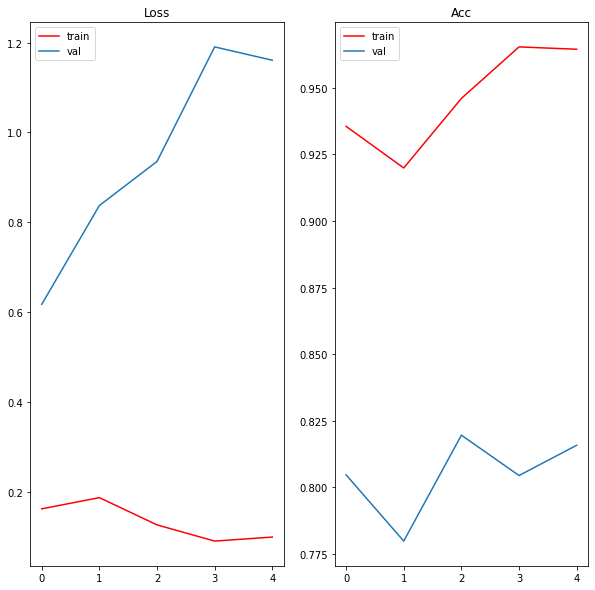

In [10]:
hist = train_loop(model, lossf,otimizer, dataloader_train, dataloader_val, device, epochs=5)

In [11]:
test_loop(model, lossf, dataloader_test, device)

The model obtained an accuracy of 0.844, and a loss of 0.737


In [12]:
 with torch.cuda.device(device):
            torch.cuda.empty_cache()

## Pretrained net

In [40]:
model_restnet = models.resnet34(pretrained=True)
for param in model_restnet.parameters():
    param.required_grad = False

In [41]:
nr_feat = model_restnet.fc.in_features
model_restnet.fc = torch.nn.Sequential(OrderedDict([
    ('fc', torch.nn.Linear(nr_feat, 2))
]))

In [42]:
# model_restnet.fc.parameters.required_grad = True
for param in model_restnet.fc.parameters():
    param.required_grad = True

In [43]:
model_restnet.to(device);

In [44]:
optimizer2 = torch.optim.Adam(model_restnet.parameters())

Epoch [30/30]: 100%|██████████| 30/30 [18:36<00:00, 37.23s/it, loss=0.03, val_loss=0.649]


{'epoch': 30}

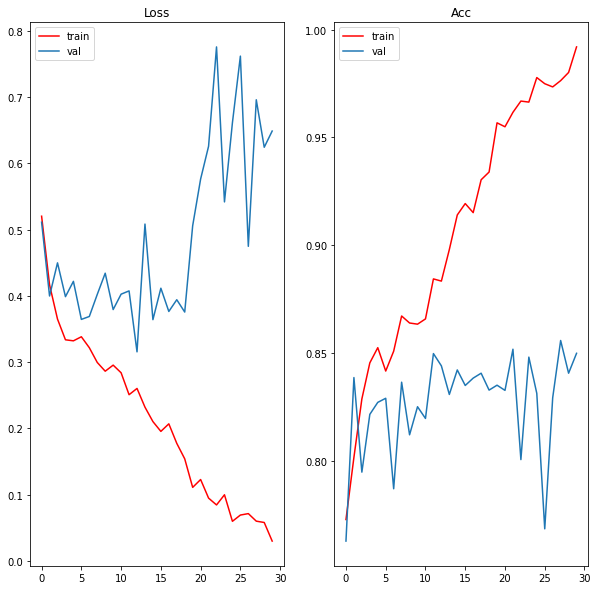

In [45]:
train_loop(model_restnet, lossf, optimizer2, dataloader_train, dataloader_val, device, epochs=30, early_stop=False)

In [46]:
for layer in model_restnet.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

Epoch [5/5]: 100%|██████████| 5/5 [03:08<00:00, 37.65s/it, loss=0.133, val_loss=0.778]


{'epoch': 5}

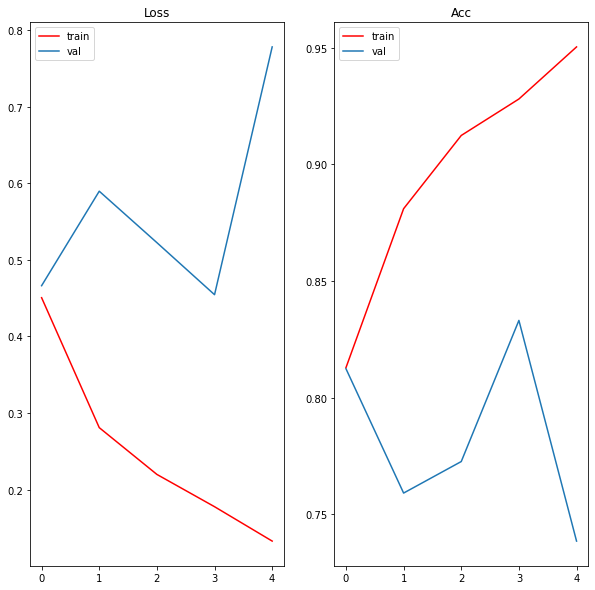

In [47]:
train_loop(model_restnet, lossf,optimizer2,  dataloader_train, dataloader_val, device, epochs=5)

In [49]:
test_loop(model_restnet, lossf, dataloader_test, device)

The model obtained an accuracy of 0.771, and a loss of 0.687


## The performance is about the same